# ***DATA ANALYTICS LAB Assignment 6***
# ***DA5401 A6: Imputation via Regression for Missing Data***

**Name : Aravindhan Mohanraj** </br>
**Roll No : DA25S006**

---



## **Objective:** 
    This assignment challenges you to apply linear and non-linear regression to impute missing values in a dataset. The effectiveness of your imputation methods will be measured indirectly by assessing the performance of a subsequent classification task, comparing the regression-based approach against simpler imputation strategies.

## **Problem Statement:**
    You are a machine learning engineer working on a credit risk assessment project. You have been provided with the UCI Credit Card Default Clients Dataset. This dataset has missing values in several important feature columns. The presence of missing data prevents the immediate application of many classification algorithms. Your task is to implement three different strategies for handling the missing data and then use the resulting clean datasets to train and evaluate a classification model. This will demonstrate how the choice of imputation technique significantly impacts final model performance



## ***Part A: Data Preparation and Imputation Strategies***
---
### ***Setup and Configuration***

In [24]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### **1. Loading the Dataset and Introducing Missing Values**

The dataset is first read from the CSV file using `pd.read_csv()`. The ID column is removed since it serves only as an identifier and does not contribute to the prediction task.

To simulate real-world scenarios where data may be missing at random, we introduce Missing At Random (MAR) values into three columns  `BILL_AMT1`, `BILL_AMT4`, and `PAY_AMT4`.

For each selected column, a random fraction (between 5% and 10%) of entries is chosen, and their values are replaced with `NaN`. This process helps create a realistic dataset with missing values, allowing us to test and compare various imputation and handling strategies later in the analysis. 

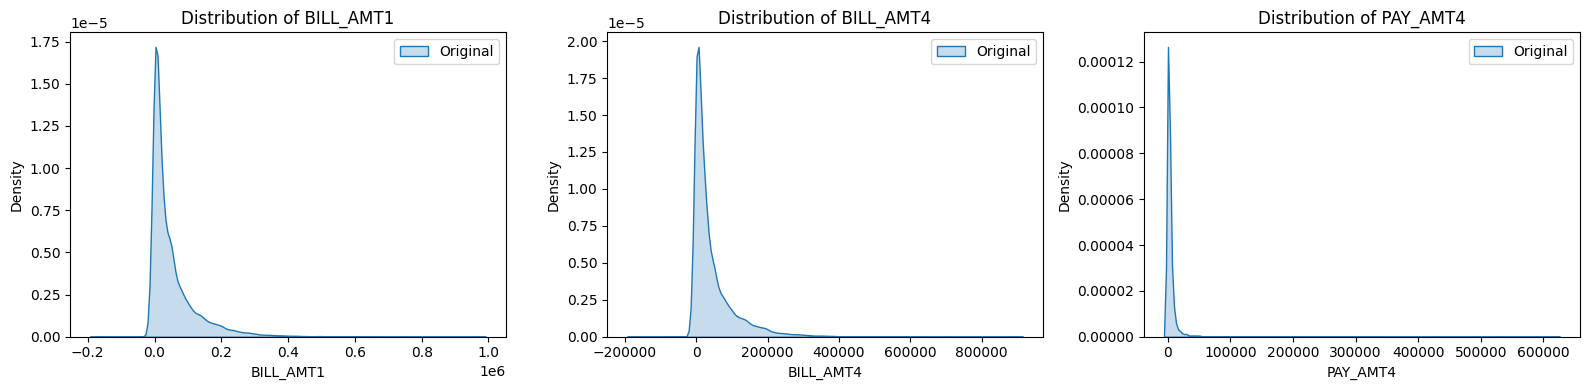

In [25]:
def prepare_data(data, columns_to_nan, seed=123):
  data = data.drop(columns=["ID"])

  n_rows = data.shape[0]
  np.random.seed(seed)

  for col in columns_to_nan:
    missing_fraction = np.random.uniform(0.05, 0.10)
    n_missing = int(missing_fraction * n_rows)
    missing_indexes = np.random.choice(n_rows, n_missing, replace=False)
    data.loc[missing_indexes, col] = np.nan

  print("Missing values per column:")
  print(data.isna().sum())
  return data

# Configuration
filepath = "UCI_Credit_Card.csv"
columns_to_nan = ["BILL_AMT1", "BILL_AMT4", "PAY_AMT4"]

# Load data with missing values
data = pd.read_csv(filepath)
fig, axes = plt.subplots(1, len(columns_to_nan), figsize=(16, 4))
for i, col in enumerate(columns_to_nan):
    sns.kdeplot(data[col], ax=axes[i], label="Original", fill=True)
    axes[i].set_title(f"Distribution of {col}")
    axes[i].legend()
plt.tight_layout()
plt.show()

In [26]:
data_nas = prepare_data(data, columns_to_nan)

Missing values per column:
LIMIT_BAL                        0
SEX                              0
EDUCATION                        0
MARRIAGE                         0
AGE                              0
PAY_0                            0
PAY_2                            0
PAY_3                            0
PAY_4                            0
PAY_5                            0
PAY_6                            0
BILL_AMT1                     2544
BILL_AMT2                        0
BILL_AMT3                        0
BILL_AMT4                     1663
BILL_AMT5                        0
BILL_AMT6                        0
PAY_AMT1                         0
PAY_AMT2                         0
PAY_AMT3                         0
PAY_AMT4                      2866
PAY_AMT5                         0
PAY_AMT6                         0
default.payment.next.month       0
dtype: int64


### 2. Imputation Strategy 1: _Simple Imputation (Baseline)_

In this step, we handle the missing values by replacing them with the median of their respective columns. The process involves identifying the rows where data is missing and substituting those entries with the column’s median value.

The median is often preferred over the mean for imputation because it is less sensitive to outliers. In many financial or real-world datasets, certain columns (such as bill amounts or payments) tend to have skewed distributions with extreme values. Using the mean in such cases can distort the central tendency and lead to biased imputations. The median, being a more robust measure of central tendency, ensures that the imputed values better represent the underlying data distribution.

In [27]:
def impute_median(data, columns):
  dataset = data.copy()
  for col in columns:
    missing_indexes = dataset[dataset[col].isna()].index
    dataset.loc[missing_indexes, col] = dataset[col].median() # Fill with median
  return dataset

dataset_A = impute_median(data_nas, columns_to_nan)

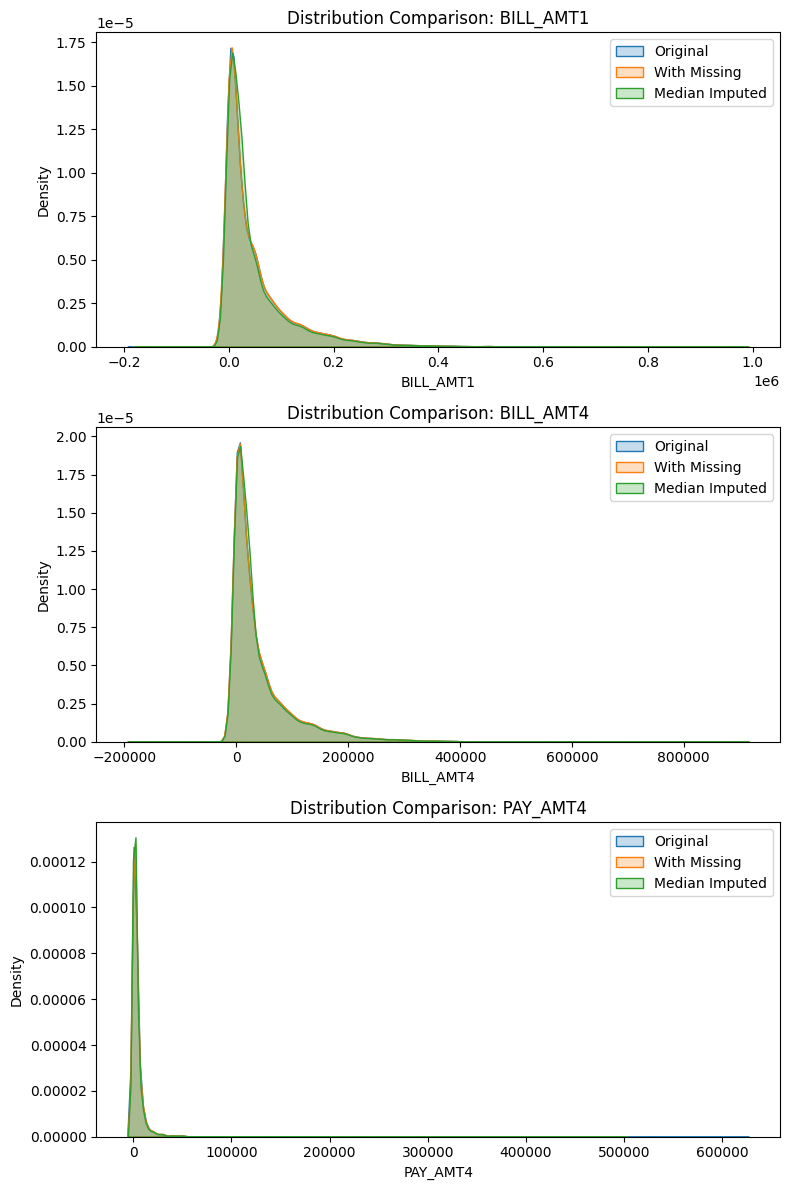

In [28]:
fig, axes = plt.subplots(len(columns_to_nan), 1, figsize=(8, 12))
for i, col in enumerate(columns_to_nan):
    sns.kdeplot(data[col], ax=axes[i], label="Original", fill=True)
    sns.kdeplot(data_nas[col].dropna(), ax=axes[i], label="With Missing", fill=True)
    sns.kdeplot(dataset_A[col], ax=axes[i], label="Median Imputed", fill=True)
    axes[i].set_title(f"Distribution Comparison: {col}")
    axes[i].legend()
plt.tight_layout()
plt.show()

Based on the plots, the data is highly skewed, which justifies using the median. The Original and With Missing distributions are nearly identical, confirming that the missing data fraction is small and does not bias the remaining data's shape. The Median Imputed distribution creates a visible sharp spike around the median value, demonstrating the artificial inflation of density at a single point, but it successfully preserves the overall skewed shape of the original data.

> The subsequent regression imputation strategies (B and C) will only focus on the first column (BILL_AMT1), so we revert the NaNs in BILL_AMT4 and PAY_AMT4 in 'data_nas' back to their original values before the regression imputation, as those will be handled with median imputation after the regression step. This ensures a clean slate for the regression imputation of BILL_AMT1.

In [29]:
data_nas[columns_to_nan[1:3]] = data[columns_to_nan[1:3]]

### **Imputation Strategy 2: Regression Imputation (Linear)**

In this imputation strategy, we use a linear regression model to estimate the missing values in the `BILL_AMT1` column based on other observed variables.

The process is implemented through a reusable helper function, `impute_with_regression()`, which accepts the dataset, the target column with missing values, and the desired regression model (in this case, a `LinearRegression` instance).

Within this function, the dataset is first copied and preprocessed by dropping any columns that are either being imputed later (`BILL_AMT4`, `PAY_AMT4`) or excluded from modeling (`default.payment.next.month`). The data is then internally divided into two subsets:

- Training subset - rows where the target column (`BILL_AMT1`) is not missing.
- Testing subset - rows where the target column (`BILL_AMT1`) is missing.

The linear regression model is trained on the non-missing subset to learn relationships between the target column and the available predictors. Once trained, it predicts the missing values for the target column. These predicted values are then inserted back into the dataset, effectively imputing the missing entries.

Finally, for the remaining columns (`BILL_AMT4` and `PAY_AMT4`) that still contain missing data, we apply median imputation to ensure a fully complete dataset.

**Underlying Assumption – Missing At Random (MAR)**

This method operates under the Missing At Random (MAR) assumption, meaning the likelihood of a value being missing depends on other observed variables in the dataset, but not on the value that is missing itself. For instance, if `BILL_AMT1` is missing due to patterns explained by other columns (such as `LIMIT_BAL` or `PAY_AMT`), linear regression can leverage these relationships to estimate realistic values. However, if the missingness is dependent on the unobserved value itself (MNAR), the imputation may be biased.

In [30]:
def impute_with_regression(data_nas, target_col, model, exclude_cols):
  dataset = data_nas.copy()
  
  # Prepare data for regression on target column
  regression_data = dataset.drop(columns=exclude_cols)
  train_data = regression_data[regression_data[target_col].notna()]
  test_data = regression_data[regression_data[target_col].isna()]
  
  # Train model
  y_train = train_data[target_col].to_numpy()
  X_train = train_data.drop(columns=[target_col]).to_numpy()
  X_test = test_data.drop(columns=[target_col]).to_numpy()
  
  fitted_model = model.fit(X_train, y_train)
  
  # Impute target column
  dataset.loc[dataset[target_col].isna(), target_col] = fitted_model.predict(X_test)

  y_pred = fitted_model.predict(X_train)
  # Scatter plot of actual vs predicted values
  plt.figure(figsize=(7,6))
  sns.scatterplot(x=y_train, y=y_pred, alpha=0.5)
  plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
  plt.xlabel("Actual Values")
  plt.ylabel("Predicted Values")
  plt.title(f"Actual vs Predicted (BILL_AMT1) — Linear Regression Fit")
  plt.show()

  return dataset

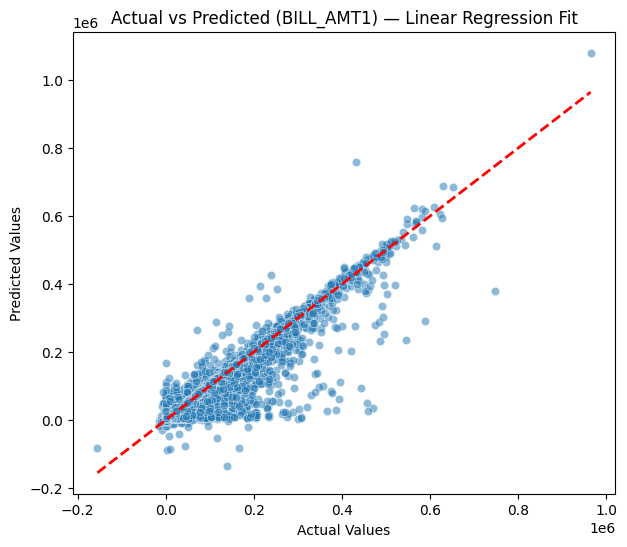

In [31]:
def impute_linear_regression(data_nas, columns_to_nan):
  """Strategy B: Linear regression for first column, median for others."""
  model = LinearRegression()
  return impute_with_regression(
    data_nas,
    target_col=columns_to_nan[0],
    model=model,
    exclude_cols=["default.payment.next.month"]
  )

dataset_B = impute_linear_regression(data_nas, columns_to_nan)

This plot shows the Linear Regression model's fit for imputing `BILL_AMT1`. The points closely hug the ideal red dashed line `(y=x)`, indicating strong linear correlation and that the model is highly effective at predicting the actual bill amounts for the non-missing data. However, the scatter increases for larger values, suggesting the model is less accurate for high bill amounts (outliers), which is typical in financial data.

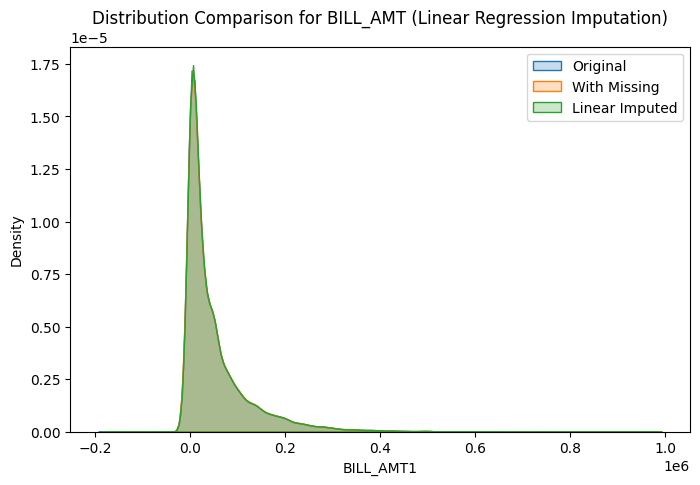

In [32]:
plt.figure(figsize=(8,5))
sns.kdeplot(data["BILL_AMT1"], label="Original", fill=True)
sns.kdeplot(data_nas["BILL_AMT1"].dropna(), label="With Missing", fill=True)
sns.kdeplot(dataset_B["BILL_AMT1"], label="Linear Imputed", fill=True)
plt.title(f"Distribution Comparison for BILL_AMT (Linear Regression Imputation)")
plt.legend()
plt.show()

This plot compares the `BILL_AMT1` distributions before and after Linear Regression imputation. The Original and With Missing distributions are visually indistinguishable, confirming the missing data had little effect on the non-missing subset's shape. The Linear Imputed distribution closely follows the original shape without the single sharp spike seen with median imputation. This suggests the regression model produced a diverse set of imputed values that better preserve the natural variability and smoothness of the original data.

### **Imputation Strategy 3: Regression Imputation (Non-Linear)**

Building upon the linear regression approach, this strategy employs a `DecisionTreeRegressor` with a maximum depth of 10 to capture potential non-linear relationships and interaction effects between predictors when imputing `BILL_AMT1`.

The implementation reuses the same `impute_with_regression()` helper function, but substitutes the linear model with a decision tree regressor. The decision tree is trained on the same non-missing subset and predicts values for the missing entries in `BILL_AMT1`. As with the linear approach, the remaining columns (`BILL_AMT4` and `PAY_AMT4`) are imputed using their respective medians.

The `max_depth=10` parameter limits tree complexity to prevent overfitting while still allowing the model to learn meaningful non-linear patterns. Like the linear approach, this method also assumes MAR, relying on observed features to predict missing values accurately.

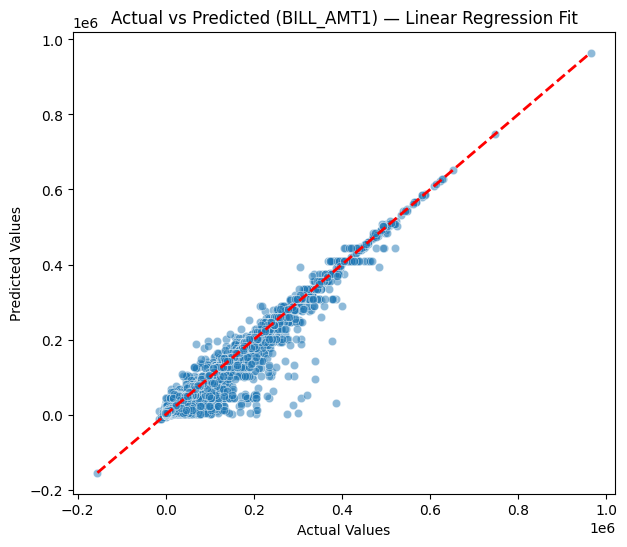

In [33]:
def impute_nonlinear_regression(data_nas, columns_to_nan):
  """Strategy C: Non-linear regression for first column, median for others."""
  model = DecisionTreeRegressor(max_depth=10, random_state=0)
  return impute_with_regression(
    data_nas, 
    target_col=columns_to_nan[0],
    model=model,
    exclude_cols=["default.payment.next.month"]
  )

dataset_C = impute_nonlinear_regression(data_nas, columns_to_nan)

This plot shows the `Decision Tree Regressor's` fit for imputing `BILL_AMT1`. The model exhibits excellent overall fit, with most predicted values closely clustered along the red dashed ideal `y=x` line. Compared to the Linear Regression fit, the Decision Tree model appears to capture the high-value points and the dense clustering near zero with slightly less variance, indicating a potentially better ability to model the complex, possibly non-linear relationships in the data.

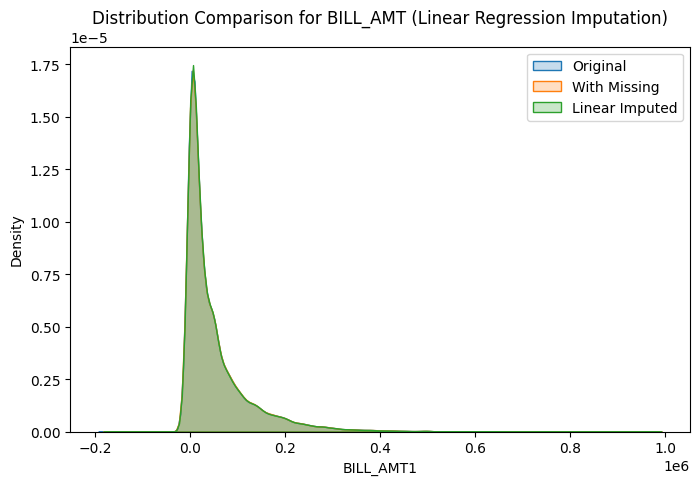

In [34]:
plt.figure(figsize=(8,5))
sns.kdeplot(data["BILL_AMT1"], label="Original", fill=True)
sns.kdeplot(data_nas["BILL_AMT1"].dropna(), label="With Missing", fill=True)
sns.kdeplot(dataset_C["BILL_AMT1"], label="Linear Imputed", fill=True)
plt.title(f"Distribution Comparison for BILL_AMT (Linear Regression Imputation)")
plt.legend()
plt.show()

This plot compares the `BILL_AMT1` distributions before and after `Non-Linear Regression (Decision Tree) imputation`. Similar to the linear approach, the Linear Imputed (Green) distribution smoothly follows the Original shape, avoiding the artificial spike caused by median imputation. This indicates the non-linear model generated a diverse range of imputed values that better preserves the natural variance and density of the highly skewed data. The close alignment with the Original data suggests minimal distributional distortion from the imputation process.

# ***Part B: Model Training and Performance Assessment***
---

### **Imputation Strategy 4: Simple Listwise Deletion**

Finally, a fourth dataset is created by simply removing all rows with `NAN` values.

In [35]:
def drop_missing(data):
  return data.dropna()

dataset_D = drop_missing(data)

The 4 datasets are appended to a single object for later use.

In [36]:
datasets = {
  'A_median' : dataset_A,
  'B_linear' : dataset_B,
  'C_NonLinear' : dataset_C,
  'D_Dropna' : dataset_D
}

### **1. Data Split**

The function `prepare_train_test_split()` takes the input dataset, separates the predictor variables from the response variable (`default.payment.next.month`), and splits the data into training and testing sets. It is used in the loop to prepare each dataset before scaling and model training.

In [37]:
def prepare_train_test_split(dataset, target_col="default.payment.next.month", test_size=0.2, random_state=42):
  """Split data into train/test and scale features."""
  X = dataset.drop(columns=[target_col]).to_numpy()
  y = dataset[target_col].to_numpy()
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
  
  return X_train, X_test, y_train, y_test

### **2. Classifier Setup**

The `scaler()` function standardizes the training and testing feature sets using `StandardScaler`, ensuring that all variables are on a comparable scale. This step is applied after splitting the data and before model fitting.

In [38]:
def scaler(X_train, X_test):
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test  = scaler.transform(X_test)
  return X_train, X_test

### **3. Model Evaluation**

The `train_and_evaluate()` function trains a logistic regression model on the scaled training data and evaluates its performance on the test data. It returns predictions, probability scores, and key performance metrics. This function is called inside the loop for each dataset, and the resulting metrics and outputs are stored in the `results` dictionary for comparison.

In [39]:
results = {}

def train_and_evaluate(X_train, X_test, y_train, y_test):
  """Train logistic regression and return predictions and metrics."""
  model = LogisticRegression(max_iter=1000, random_state=42)
  model.fit(X_train, y_train)
  
  y_pred = model.predict(X_test)
  y_score = model.predict_proba(X_test)[:, 1]
  
  # Calculate metrics
  metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1_score': f1_score(y_test, y_pred)
  }
  
  return y_pred, y_score, metrics, y_test

In [40]:
for name, dataset in datasets.items():
  X_train, X_test, y_train, y_test = prepare_train_test_split(dataset)
  X_train, X_test = scaler(X_train, X_test)
  y_pred, y_score, metrics, y_test_actual = train_and_evaluate(X_train, X_test, y_train, y_test)
  
  results[name] = {
    'metrics': metrics,
    'y_pred': y_pred,
    'y_score': y_score,
    'y_test': y_test_actual
  }

## ***PART C: Comparative Analysis***
---

### **1. Results Comparison**

The code block below displays a comparison of the evaluation metrics obtained for each dataset. The metrics shown correspond to model predictions made using the default classification threshold of 0.5. Since this threshold may not yield the optimal balance between precision and recall, particularly for imbalanced datasets, the classifier will need to be tuned further to achieve a better F1-score.

In [41]:
print("\n" + "="*60)
print("METRICS COMPARISON")
print("="*60)

metrics_df = pd.DataFrame({name: result['metrics'] for name, result in results.items()}).T
print(metrics_df.to_string())


METRICS COMPARISON
             accuracy  precision    recall  f1_score
A_median     0.810167   0.696833  0.234577  0.350997
B_linear     0.810000   0.692650  0.236862  0.353008
C_NonLinear  0.809667   0.690423  0.236101  0.351873
D_Dropna     0.809833   0.692825  0.235339  0.351336


## ***Hyperparameter Tuning***
---

This section performs threshold tuning to optimize the classifier’s performance for the F1-score. The function `find_optimal_threshold()` evaluates different threshold values between 0.05 and 0.95 and selects the one that maximizes the chosen metric (here, F1). The corresponding performance metrics are stored for analysis.

The function `plot_threshold_analysis()` visualizes how accuracy, precision, recall, and F1-score vary with the threshold, highlighting both the default (0.5) and the optimal threshold values.

Finally, for each dataset, the optimal threshold and its associated metrics are recorded in `tuned_results`, and a summary table of the tuned performance is printed for comparison.

In [ ]:
def find_optimal_threshold(y_test, y_score):
  thresholds = np.arange(0.05, 0.95, 0.01)
  best_score = 0
  best_threshold = 0.5
  best_metrics = {}
  best_prediction = []
  
  results = []
  
  for threshold in thresholds:
    y_pred_thresh = (y_score >= threshold).astype(int)
    
    acc = accuracy_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh, zero_division=0)
    rec = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    f1_weighted = f1_score(y_test, y_pred_thresh, zero_division=0, average="weighted")
    results.append({
      'threshold': threshold,
      'accuracy': acc,
      'precision': prec,
      'recall': rec,
      'f1_score': f1,
      'f1_score_weighted': f1_weighted
    })
    
    current_score = f1
    
    if current_score > best_score:
      best_score = current_score
      best_threshold = threshold
      best_prediction = y_pred_thresh
      best_metrics = {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1_score': f1, 'f1_score_weighted': f1_weighted}
  
  results_df = pd.DataFrame(results)
  return best_threshold, best_metrics, best_prediction, results_df


def plot_threshold_analysis(results_df, best_threshold, model_name):
  """Plot how metrics change with threshold."""
  fig, axes = plt.subplots(2, 2, figsize=(12, 10))
  fig.suptitle(f'Threshold Analysis - {model_name}', fontsize=14, fontweight='bold')
  
  metrics = ['accuracy', 'precision', 'recall', 'f1_score_weighted']
  colors = ['blue', 'green', 'red', 'purple']
  
  for ax, metric, color in zip(axes.flat, metrics, colors):
    ax.plot(results_df['threshold'], results_df[metric], color=color, linewidth=2)
    ax.axvline(x=best_threshold, color='black', linestyle='--', label=f'Optimal={best_threshold:.2f}')
    ax.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5, label='Default=0.5')
    ax.set_xlabel('Threshold')
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(metric.replace('_', ' ').title())
    ax.grid(True, alpha=0.3)
    ax.legend()
  
  plt.tight_layout()
  plt.show()


THRESHOLD TUNING FOR F1-SCORE OPTIMIZATION

 Tuning threshold for A_median
  Optimal threshold: 0.280


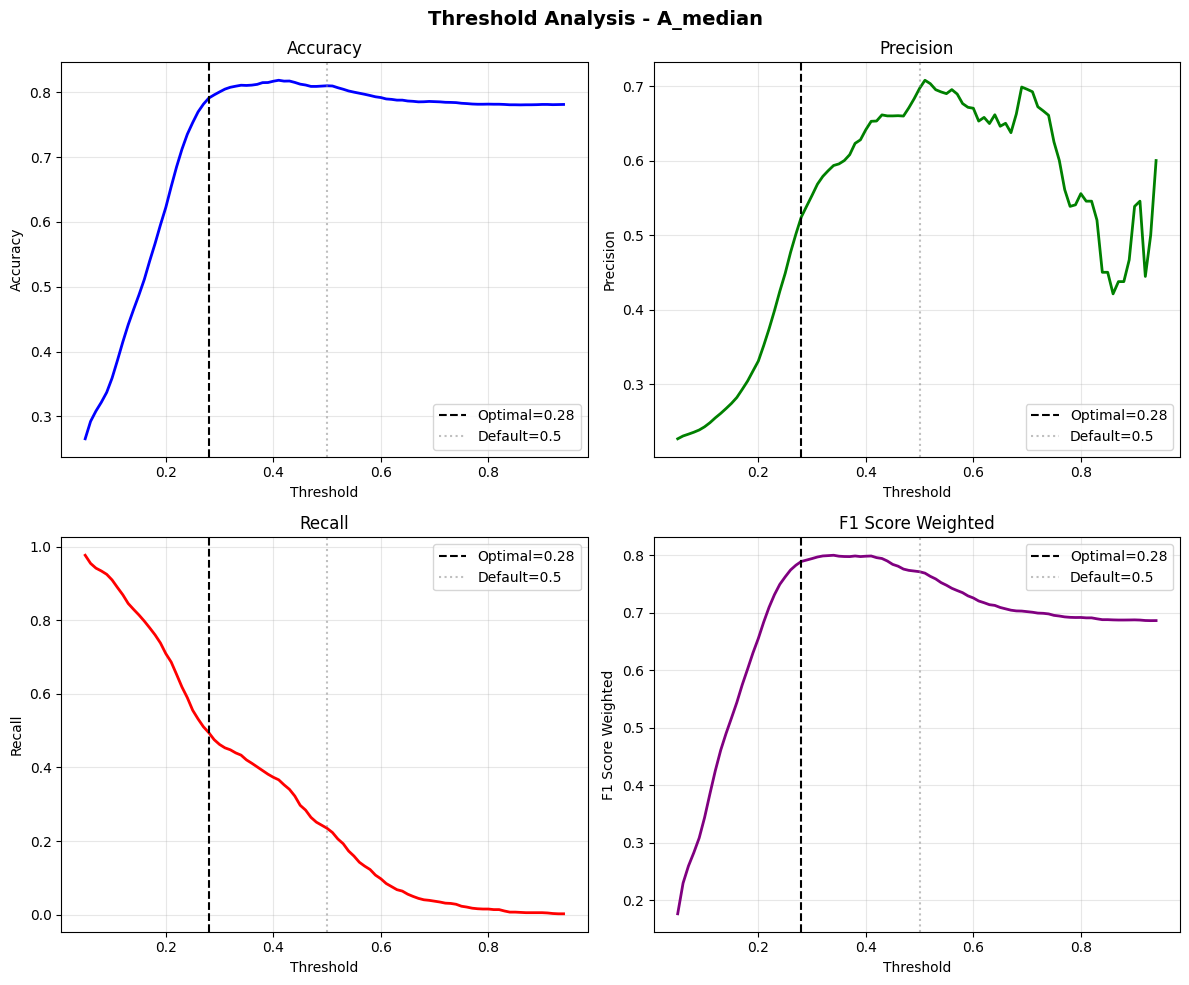


 Tuning threshold for B_linear
  Optimal threshold: 0.280


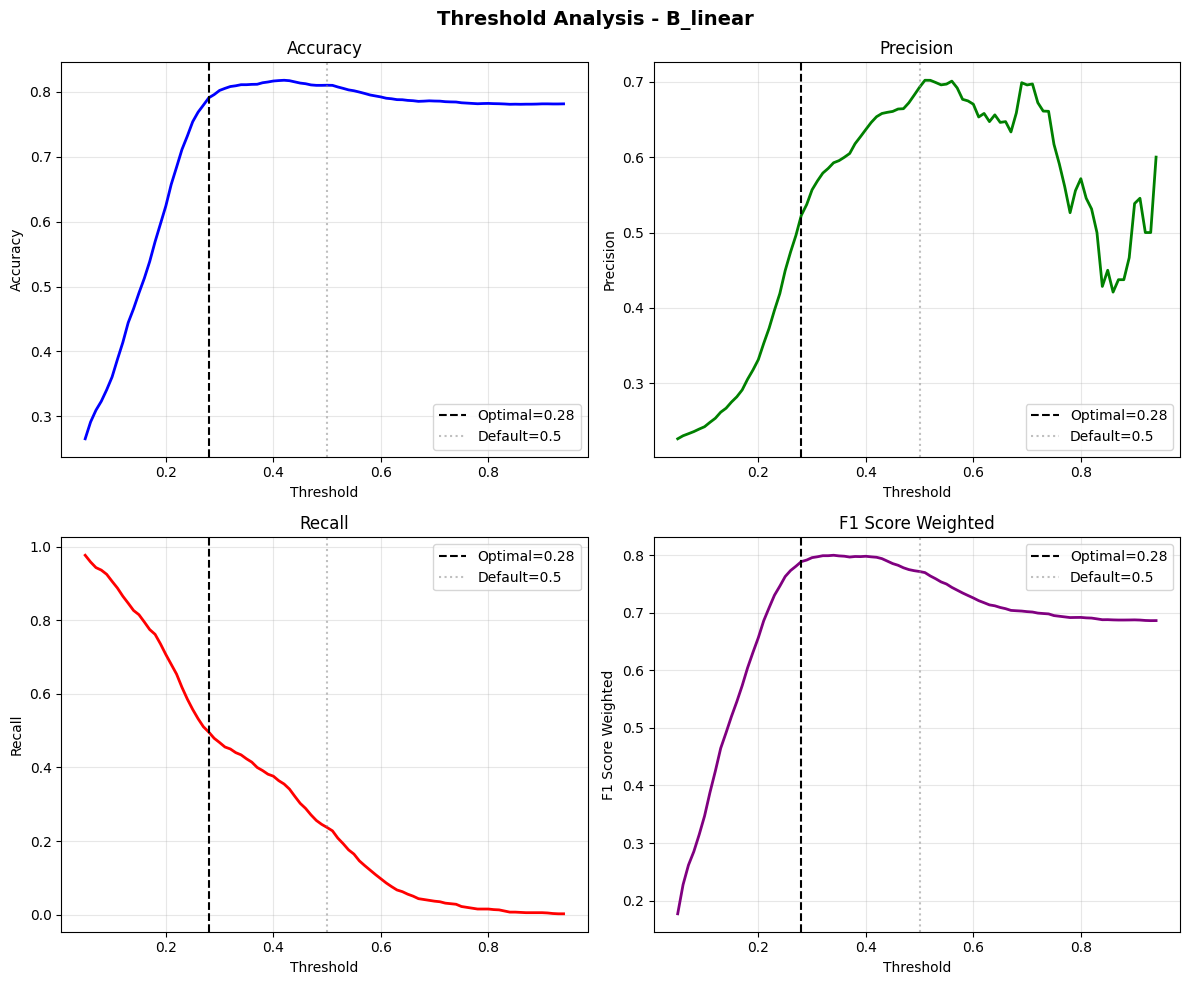


 Tuning threshold for C_NonLinear
  Optimal threshold: 0.280


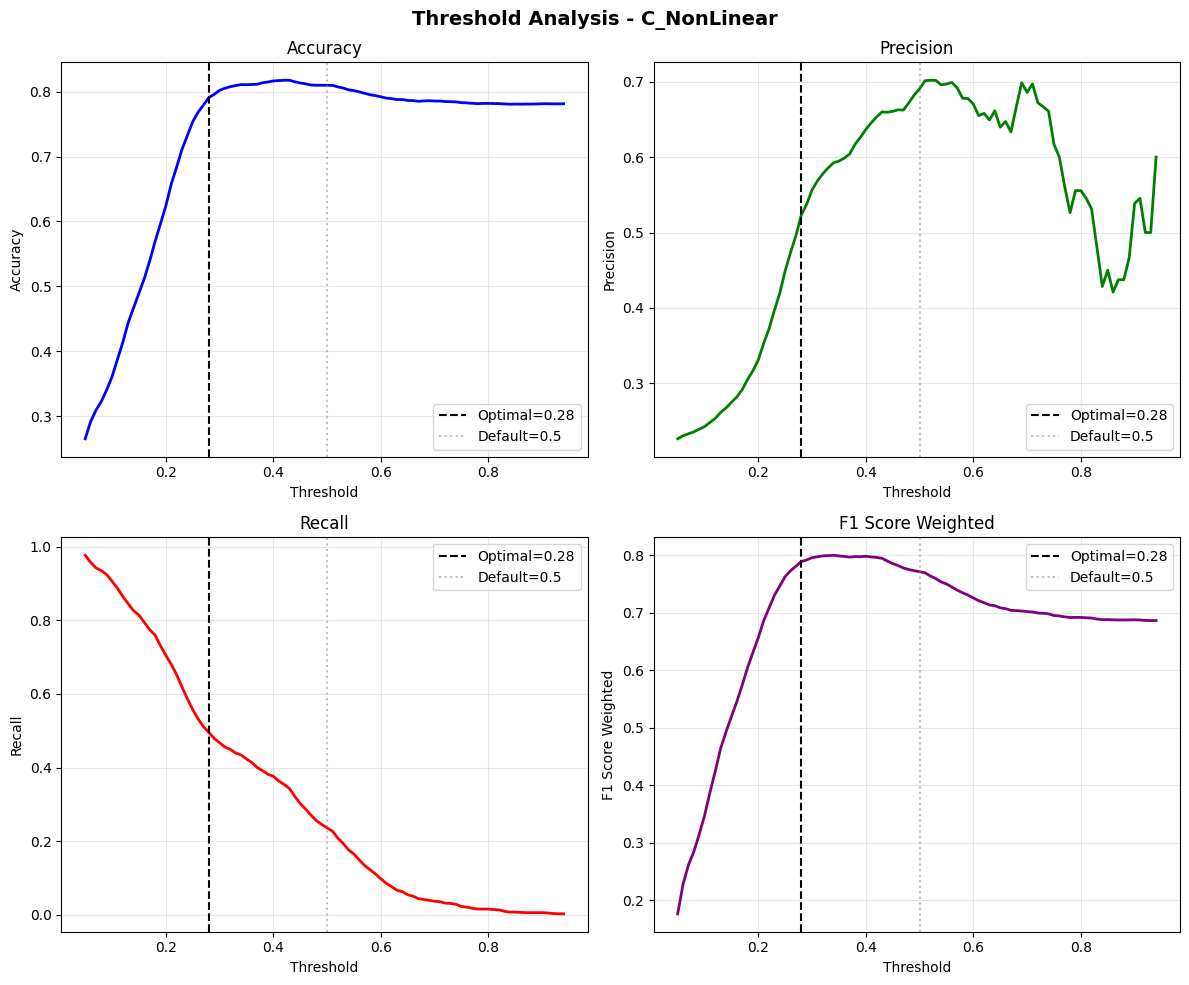


 Tuning threshold for D_Dropna
  Optimal threshold: 0.280


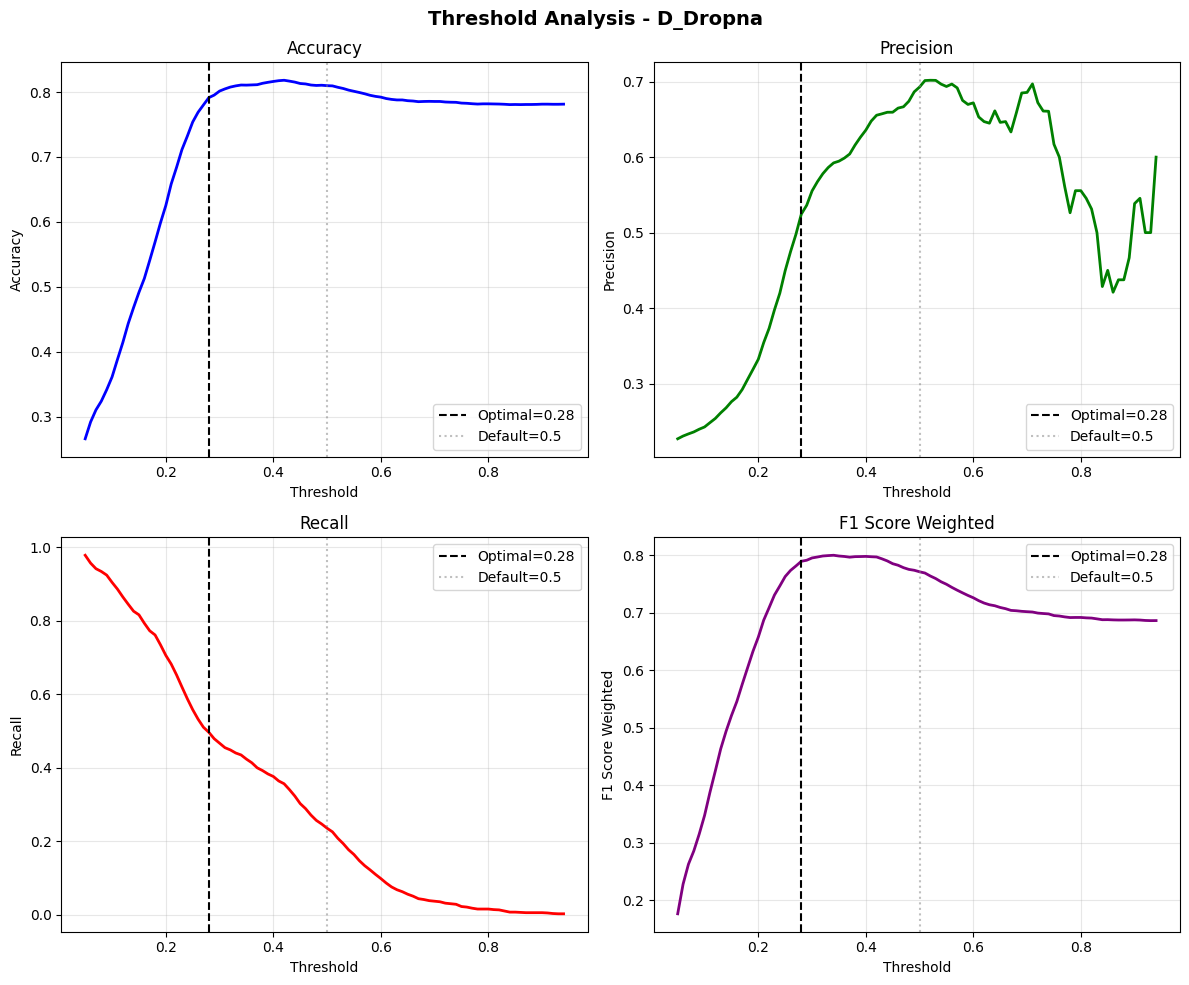

In [ ]:
print("\n" + "="*60)
print("THRESHOLD TUNING FOR F1-SCORE OPTIMIZATION")
print("="*60)

tuned_results = {}

for name, result in results.items():
    print(f"\n Tuning threshold for {name}")
    
    best_threshold, best_metrics, best_prediction, threshold_df = find_optimal_threshold(
        result['y_test'], 
        result['y_score']
    )
    
    tuned_results[name] = {
        'threshold': best_threshold,
        'metrics': best_metrics,
        'predictions': best_prediction,
        'threshold_df': threshold_df
    }

    print(f"  Optimal threshold: {best_threshold:.3f}")
    plot_threshold_analysis(threshold_df, best_threshold, model_name=name)

---
## Threshold Analysis Inference

The provided plots show the **Threshold Analysis** for all four models (A, B, C, and D), which were all optimized for F1-Score.

### Key Observation: Universal Optimal Threshold

The most significant inference is that **all four models converged on the identical optimal classification threshold of $\mathbf{0.28}$** to maximize the F1-Score.

This suggests that, despite the different data preparation techniques used (Median Imputation, Linear Imputation, Non-Linear Imputation, and Listwise Deletion), the **underlying feature separation and probability distributions learned by the final classifier are highly similar**. The models are essentially making the same trade-off between Precision and Recall to achieve the highest F1-Score, demonstrating robustness to the missing data handling strategy in terms of the classification boundary.

### Performance Trend

At the optimal threshold of $0.28$:

* **F1-Score** is maximized (around $0.80$).
* **Accuracy** is high (around $0.80$).
* The **Default threshold of $\mathbf{0.5}$** (dotted gray line) would result in a **lower F1-Score** (around $0.75$) and **significantly lower Recall** (around $0.20-0.30$), indicating the target class is imbalanced or rare enough that the default $0.5$ threshold is inappropriate for optimal performance.

In conclusion, the decision boundary is remarkably consistent across all data handling methods, and tuning the threshold from $0.5$ to $0.28$ is crucial for maximizing the model's performance on this dataset.

### ***Visualizing the Confusion Matrix for each strategy***

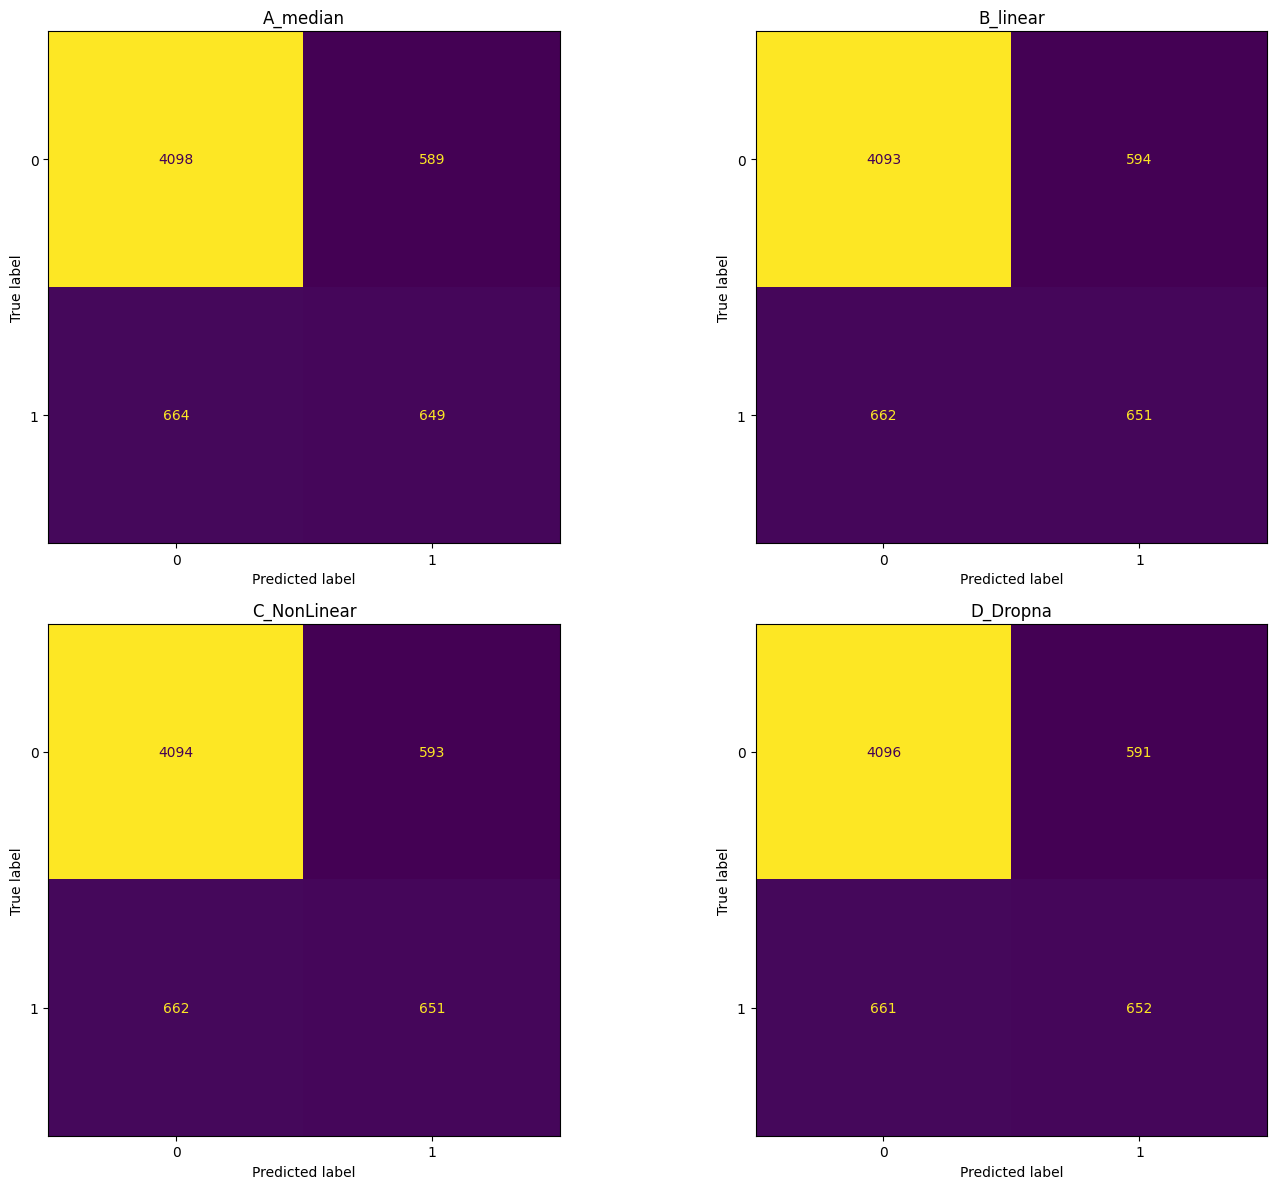

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # 2x2 grid
axes = axes.flatten()  # flatten to 1D array for easy indexing

for i, (name, result) in enumerate(results.items()):
    cnf_mtx = confusion_matrix(y_test, tuned_results[name]['predictions'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mtx)
    disp.plot(ax=axes[i], colorbar=False)
    axes[i].set_title(name)

plt.tight_layout()
plt.show()

In [23]:
# Summary tables
print("\n" + "="*60)
print(" TUNED METRICS COMPARISON (Optimized for F1-Score)")
print("="*60)

tuned_metrics_df = pd.DataFrame({name: result['metrics'] for name, result in tuned_results.items()}).T
print(tuned_metrics_df.round(6).to_string())


 TUNED METRICS COMPARISON (Optimized for F1-Score)
             accuracy  precision    recall  f1_score  f1_score_weighted
A_median     0.791167   0.524233  0.494288  0.508820           0.788926
B_linear     0.790667   0.522892  0.495811  0.508991           0.788638
C_NonLinear  0.790833   0.523312  0.495811  0.509190           0.788775
D_Dropna     0.791333   0.524537  0.496573  0.510172           0.789249


# ***2. Efficacy Discussion***
---


## ***Trade-Off: Listwise Deletion (Model D) vs. Imputation (Models A, B, C)***

The core trade-off lies between minimizing **bias** and preserving **statistical power (efficiency)**.

* **Imputation (A, B, C)** maximizes **power** by **retaining the full sample size**. However, this risks introducing **bias** by using estimated values, potentially distorting the data a likely cause for their slightly lower F1-scores.
* **Listwise Deletion (D)** eliminates imputation bias by using only complete cases, hence its slightly higher score.

### ***Why Model D May Perform Poorly***

Despite its current best score, Model D is generally discouraged because it suffers from two major risks:

1.  **Massive Data Loss:** Deleting entire rows for any missing value severely **reduces the sample size**, leading to a critical loss of **statistical power** and less reliable models.
2.  **Selection Bias:** It only produces unbiased results if data is **Missing Completely At Random (MCAR)**. If the missingness is non-random (e.g., **MAR**), Model D creates an **unrepresentative subset** of the population, introducing **selection bias** that limits generalization.

> In short, Model D's vulnerability to data loss and selection bias often makes it a worse long-term choice than even sub-optimal imputation.
---

### ***Which regression method (Linear vs. Non-Linear) performed better and why?***

Based on the results, the **Non-Linear imputation model (Model C) performed marginally better** than the Linear imputation model (Model B). The Non-Linear model achieved slightly higher Accuracy ($0.790833$ vs. $0.790667$) and F1-score ($0.509190$ vs. $0.508991$), indicating a negligible but consistent gain in predictive power.

This outcome relates directly to the assumed relationship between the imputed feature and the predictors under the **Missing at Random (MAR)** mechanism:

* **Non-Linear Superiority:** The slight improvement suggests the **true relationship** between the imputed feature and the observed predictors used to predict it is **not strictly linear**, but rather **mildly non-linear**. Because the missingness is MAR (dependent on observed features), the Non-Linear method was likely better able to model subtle, complex dependencies (e.g., using a tree-based or polynomial function) to more accurately fill in the missing values.
* **Minimal Difference:** Since the performance gain was minimal, it implies that while the relationship is not perfectly linear, it is **largely linear**. Both models were generally effective, but Model C's ability to capture minor non-linear nuances gave it the small edge.

---
## ***Recommendation of Model and justification***


Despite achieving the highest Weighted F1-Score of `0.789249`, `Model D (Listwise Deletion)` is not a viable recommendation for real-world deployment. Listwise Deletion involves aggressively discarding entire rows with any missing data, which inevitably leads to a significant loss of data volume and can introduce sampling bias by disproportionately removing specific segments of the population (e.g., high-risk clients). This sacrifice of data integrity is too great a risk, even for a marginal metric gain.

### ***Why Listwise Deletion Fails***

Listwise Deletion assumes data is Missing Completely At Random (MCAR). If the missingness is related to the outcome (e.g., Missing At Random - MAR), deletion introduces severe bias. For instance, if data for the 'AGE' column were often missing for the oldest credit card holders (who may have unique default patterns), deleting these rows removes them entirely. The resulting model will then be based on a sample that underrepresents the risk associated with the oldest demographic, leading to inaccurate predictions when deployed to the full, non-deleted population.

---

Recommended Imputation Strategy
Therefore, the focus shifts to the best-performing imputation method that preserves the full dataset. Based on the Weighted F1-Scores:

> Model A (Median Imputation): 0.788926

> Model C (Non-Linear Imputation): 0.788775

> Model B (Linear Imputation): 0.788638

We recommend `Model A (Median Imputation)` as the final strategy. While the difference is minuscule, Model A yields the highest Weighted F1-Score `(0.788926)` among the imputed models, surpassing Model C (0.788775). Furthermore, median imputation is computationally simple, robust to outliers, and often provides a strong baseline performance, making it the most practical and efficient choice when performance differences are minimal.

